### Team details {-}
Add the names of all team members and a short description of each member's contributions.   
* TEAM MEMBER 1 = Yme van der Linden (most of the coding)
* TEAM MEMBER 2 = Irfan Ahmed (helped with the coding, discussion and results)
* TEAM MEMBER 3 = Perry van Asseldonk (Discussion and Results)
* TEAM MEMBER 4 = Merel Ypinga (Discussion and Results)
* TEAM MEMBER 5 = Angela Cha (Discussion and Results)

## 1. Implementing Bayesian Optimization (60 points) {-}
* Implement Bayesian optimization using the code above and use it to optimize the hyperparameters stated below for each of the two datasets.
    - Use the hyperparameters and ranges are defined above. Make sure to sample from a log scale (`numpy.logspace`) whenever the hyperparameters should be varied on a log scale. 
    - The evaluation measure for classification should be misclassification error (1 - Accuracy), evaluated using 3-fold cross-validation
    - The evaluation measure for regression should be mean squared error, also evaluated using 3-fold cross-validation
* Initialize the surrogate model with 10 randomly sampled configurations and visualize the surrogate model.
    - Hint: Use a 2D slice of each hyperparameter (e.g. $C$=4 and $\gamma$=0.1) to show both the predicted values and the uncertainty.
    - For simplicity, you can build a separate surrogate model for each algorithm and each dataset (4 models in total) 
* Visualize the resulting acquisition function, either as 2D slices (or, more difficult, as a 3D surface)
* Visualize 3 more iterations, each time visualizing the surrogate model and acquisition function
* Run the Bayesian optimization for at least 30 iterations, report the optimal configuration and show the final surrogate model (2D slices or 3D surface).
* Interpret and explain the results. Does Bayesian optimization efficiently find good configurations? Do you notice any
differences between the different models and the different datasets. Explain the results as well as you can.

Since the procedure is very similar for the four models (Support vector machine, GradBoost, GradBoostRegressor and Elasticnet), we only provide one complete run through of our code here. For the other three models, the procedure is almost the same, the only change being the actual model used and the different hyperparameter setups. Therefore, for the other models, we only provide the chosen hyperparameters, the model initialization and the results that were obtained, alongside the discussion. The model that we will completely elaborate is the **support vector machine**. Since we had to re-use our code for four different models, we designed our code to be easily re-usable. This means that there are somewhat large callstacks and functions involved, all with designed so that our code would be "plug and play" for the other models. 

In [5]:
#Handle necessary imports
from sklearn.linear_model import ElasticNet
import numpy as np
from matplotlib import pyplot as plt
import openml as oml
from sklearn.svm import SVC
from sklearn.model_selection import  cross_validate
from sklearn.ensemble import RandomForestRegressor 
import pickle
from scipy.stats import norm
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.ensemble import GradientBoostingRegressor as GBR
np.random.seed(47)

In [6]:
#Code that was provided
class ProbabilisticRandomForestRegressor(RandomForestRegressor):
    """
    A Random Forest regressor that can also returns the standard deviations for all predictions
    """
    def predict(self, X, return_std=True):
        preds = []
        for pred in self.estimators_:
            preds.append(pred.predict(X))
        if return_std:
            return np.mean(preds, axis=0), np.std(preds, axis=0)
        else:
            return np.mean(preds, axis=0)

def EI(surrogate, X: np.ndarray, curr_best=0.0, balance=0.0, **kwargs):
    """Computes the Expected Improvement
    surrogate, The surrogate model
    X: np.ndarray(N, D), The input points where the acquisition function
    should be evaluated. N configurations with D hyperparameters
    curr_best, The current best performance
    balance, Decrease to focus more on exploration, increase to focus on exploitation (Returns
    -------
    np.ndarray(N,1), Expected Improvement of X
    """
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    m, s = surrogate.predict(X) # mean, stdev
    z = (curr_best - m - balance) / s
    f = (curr_best - m - balance) * norm.cdf(z) + s * norm.pdf(z)
    if np.any(s == 0.0): # uncertainty should never be exactly 0.0
        f[s == 0.0] = 0.0
    return f

In [24]:
#Load robot navigation data to be used in the Support vector Machine and the GradBoost Classifier
def load_nav_data():
    robotnav = oml.datasets.get_dataset(1497)
    X_nav, y_nav, cats, attrs = robotnav.get_data(dataset_format='array',
    target=robotnav.default_target_attribute)
    return X_nav, y_nav

In [8]:
#Load robot 

def load_reg_data():
    robotarm = oml.datasets.get_dataset(189)
    Xr, yr, catsr, attrsr = robotarm.get_data(dataset_format='dataframe',
    target=robotarm.default_target_attribute)
    return Xr, yr

#Load data, define parameter ranges, random parameter selections and the required slices. NOTE: For the fixed-gamma slice,
#We fixed gamma at 1/24, because the default in sklearn is 1/n_features, and the robot navigation data has 24 features. 
Xr, yr = load_reg_data()

NOTE:

We Tried to visualize the Surrogate and the Acquisition function both as 3D plots and as heatmaps. 
However, the heatmap was very messy and not too informative as there is a grid of 25 by 25 hyperparameters, 
(so 625 values in a heatmap, it gets really big and messy). Also most of the values were very close to eachother. 
The 3D plots of matplotlib don't really support logarithmic axes yet, this seems to be a known issue:

- https://stackoverflow.com/questions/3909794/plotting-mplot3d-axes3d-xyz-surface-plot-with-log-scale
- https://github.com/matplotlib/matplotlib/issues/209

Therefore we decided to stick with 2D slices, even though they are a less 'complete' way to do the hyperparameter search. 
We hope this does not affect our grade. IMAGES IN LINKS

https://ibb.co/z2kd8Wq

https://ibb.co/frxcrxs  

<H3> Q1 Support vector machine <H3>

In [25]:
#Load data, define parameter ranges, random parameter selections and the required slices. NOTE: For the fixed-gamma slice,
#We fixed gamma at 1/24, because the default in sklearn is 1/n_features, and the robot navigation data has 24 features. 
X_nav, y_nav = load_nav_data()
c_points = np.logspace(-12,12, 25)                                      #Create a range of parameter c, on a logarithmic scale, from 1e-12 to 1e12
gamma_points = np.logspace(-12, 12, 25)                                 #Create a range of parameter gamma, on a logarithmic scale, from 1e-12 to 1e12
sample_c = np.random.choice(c_points, 10 , replace=False)               #Sample 10 random points out of the parameter c range
sample_g = np.random.choice(gamma_points, 10, replace=False)            #Sample 10 random points out of the parameter gamma range

random_hyperparams = np.array(list(zip(sample_c, sample_g)))            #Zip together sample_c and sample_g, cast it to the right data structure (np.array)
c_points_gamma_fixed = np.array([(c, 1/24) for c in c_points])          #Create a np.array where c varies and gamma is fixed
gamma_points_c_fixed = np.array([(1, gamma) for gamma in gamma_points]) #Create a np.array where gamma varies and c is fixed

In [14]:
def surrogate_model_fitter(random_params, scoring_metric):
    """Function to fit the surrogate model.
     random_params: First iteration list of random params,
     later a list of random params + optimal configurations.
     scoring_metric: scoring metric to evaluate
     returns list of raw scores
     (So three scores per evaluation, one for each fold)"""
    score_list = []
    for param1, param2 in random_params:
        svc = SVC(C=param1, kernel='rbf', gamma= param2)
        score = cross_validate(svc, X_nav, y_nav, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list


def calculate_rf_input(score_list_model, classification=True):
    """Function that converts the raw score_list from
    surrogate_model_fitter into a workable value to input into the
    random forest, or later the Gaussian process. If classification is true,
    it calculates 1- the mean test accuracy (mean of three folds cross-validation).
    if false, it calculates the mean_squared error (To be used in regression dataset)"""
    if classification:
        rf_input = np.array([1 - np.mean(i['test_accuracy']) for i in score_list_model]) #Calculate the means out of the returned accuracy from the standard svm
    else:
        rf_input = np.array([abs(np.mean(i['test_neg_mean_squared_error'])) for i in score_list_model])
    return rf_input


def random_forest_fitter(score_to_fit, random_params, fixed_slice):
    """Fit the random forest, using the scores outputted by the calculate_rf_input as Y,
    and the random_param list (or later random_param + optimal setup) list as X
    We then use it on some slice to generate new predicted values in the surrogate model.
    We also compute and return the standard deviation (Sigma) for plotting and the fitted model (rf)
    for later use"""
    rf = ProbabilisticRandomForestRegressor(n_estimators=100)
    rf.fit(random_params, score_to_fit)
    Y_pred, sigma = rf.predict(fixed_slice, return_std=True)
    return Y_pred, sigma, rf


def calculate_ei(rf_param, fixed_slice):
    """Calculate expected improvement"""
    return EI(rf_param, fixed_slice)


def surr_acq_plotter(param_x_axis, y_pred_param, sigma_param, ei_score, x_axis_text):
    """Plot the surrogate function and the acquisition function"""
    plt.subplot(2,1,1)
    plt.ylabel('Surrogate model error')
    plt.xscale('log')
    plt.plot(param_x_axis, y_pred_param, 'r.' , markersize=10, label=u'Observations')
    plt.plot(param_x_axis, y_pred_param, label=u'Prediction')
    plt.fill_between(param_x_axis.ravel(),y_pred_param-2*sigma_param,y_pred_param+2*sigma_param,alpha=0.1,label='Uncertainty')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.subplot(2,1,2)
    plt.yscale('log')
    plt.xlabel('{}'.format(x_axis_text))
    plt.ylabel('Expected Improvement')
    plt.plot(param_x_axis, ei_score)
    plt.show()

In [11]:
#Callstack for the first iteration, bringing all the functions defined above together.
#For detailed overviews of the function calls please refer to the docstrings where the functions
#Are defined.
def q1_callstack( random_param: np.array, scoring_metric: str,  
                 fixed_slice: np.array, param_x_axis:str, x_axis_text: str, classification = True):
    score = surrogate_model_fitter(random_param, scoring_metric)      #Fit the surrogate model on random hyperparams, return its score
    rf_score = calculate_rf_input(score, classification)                    #Calculate the randomforest inputs 
    y, sig, rf = random_forest_fitter(rf_score, random_param, fixed_slice)  #Fit the random forest on the random parameters, make it predict for the given slice 
    ei_score = calculate_ei(rf, fixed_slice)                                #Calculate the expected improvement on this slice
    surr_acq_plotter(param_x_axis, y, sig, ei_score, x_axis_text)           #Plot the surrogate/acquisition function
    print("q1 callstack succesfully finished for {}".format(x_axis_text))   #Print statement for some feedback 
    return ei_score


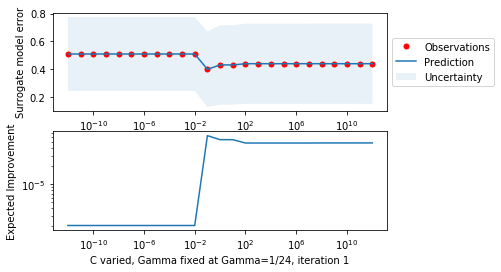

q1 callstack succesfully finished for C varied, Gamma fixed at Gamma=1/24, iteration 1


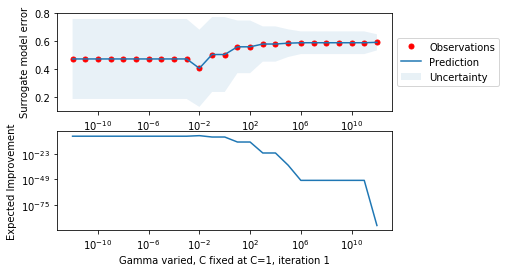

q1 callstack succesfully finished for Gamma varied, C fixed at C=1, iteration 1


In [0]:
#Generate results of the first sub-question; We define two slices, one where C varies and gamma is fixed,
#And one where Gamma is varied and C is fixed. Returns the EI score. 
ei_score_cvaried_gamma_fixed  = q1_callstack(random_hyperparams, 'accuracy', c_points_gamma_fixed, c_points, 
                                             'C varied, Gamma fixed at Gamma=1/24, iteration 1', classification=True)
ei_score_gamma_varied_c_fixed = q1_callstack(random_hyperparams, 'accuracy', gamma_points_c_fixed, gamma_points, 
                                             'Gamma varied, C fixed at C=1, iteration 1',classification=True)

#Save results to disk, so we don't have to run this again if we need it for later questions. 
with open("ei_score_cvaried_gamma_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_cvaried_gamma_fixed, f)

with open("ei_score_gamma_varied_c_fixed", "wb") as f:
    pickle.dump(ei_score_gamma_varied_c_fixed, f)


We see here that the surrogate model has the lowest error when C is about 10^-1, and when gamma is 10^-2. 
This is also where the Expected improvement is the higest.

New parameters sucessfully set, length of list is now 11


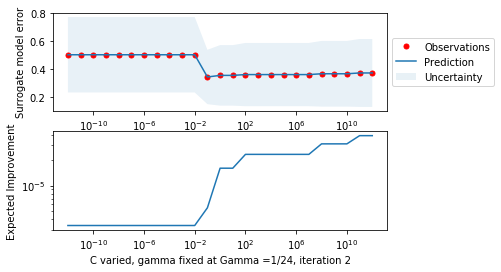

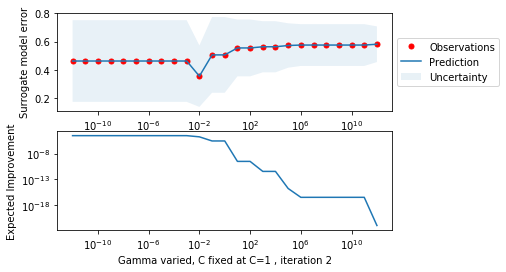

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


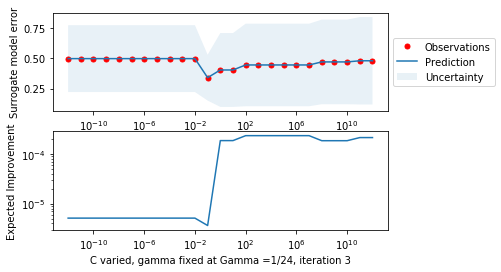

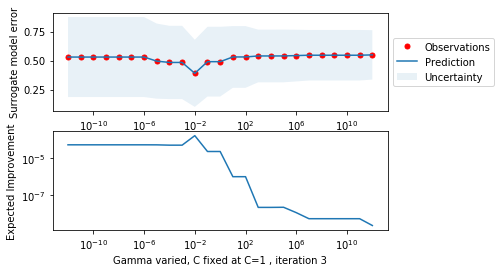

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


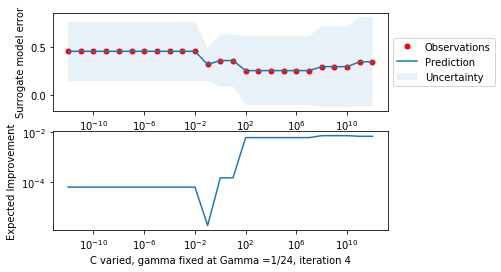

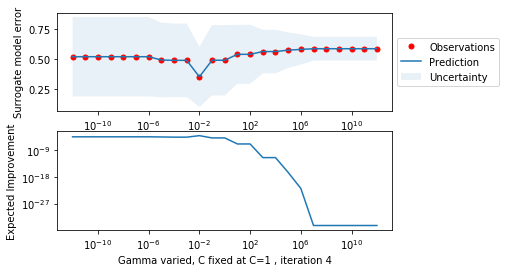

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [0]:
with open("ei_score_cvaried_gamma_fixed.pkl", "rb") as f:
    ei_score_cvaried_gamma_fixed = pickle.load(f)

with open("ei_score_gamma_varied_c_fixed", "rb") as f:
    ei_score_gamma_varied_c_fixed = pickle.load(f)


def q1_3it_callstack(random_param: np.array,                             #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    """First, we calculate the optimal hyperparameter setup 
    from the EI results in the previous question. 
    Then we repeat the procedure 3 times. This gives us a total of 4 iterations"""
    max_ei_param_1 = np.unravel_index(np.argmax(ei_score_cvaried_gamma_fixed, axis=None), shape=ei_score_cvaried_gamma_fixed.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei_score_gamma_varied_c_fixed,  axis=None), shape=ei_score_gamma_varied_c_fixed.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)                                      #Calculate the EI-score
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = c_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = gamma_points[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

#Generate results of second sub-question (Plots for three more iterations). Like in the previous question,
#We define two slices, one where C varies and gamma is fixed, and one where gamma is varied and C is fixed.
#We then save the resulting parameter list to disk for use in later questions. 
param_list_four_iterations = q1_3it_callstack(random_hyperparams, 'accuracy', c_points_gamma_fixed, gamma_points_c_fixed, 
                                              c_points, gamma_points, "C varied, gamma fixed at Gamma =1/24", 
                                              "Gamma varied, C fixed at C=1 ", classification=True)

with open("param_list_four_iterations.pkl", "wb") as f:
    pickle.dump(param_list_four_iterations, f)

For the second iteration, we see that the surrogate model of C has the lowest error at 10^-1. A strange thing we see however,
Is that the expected improvement is guiding us towards larger C values. Expected imrpovement is highest at very large C values.
For Gamma, the error on the surrogate model is lowest 10^-2. Here the expected improvement is highest at very small values 
for gamma. 

For the third iteration, we see again that the surrogate model of C has the lowest error at 10^-1. However, the highest 
Expected improvement is at 10^11. This is a bit unexpected and strange, we would have expected it to be around 10^-1 again.
The surrogate model of Gamma we see that the error is lowest at 10-2, and maximum expected improvement is at the same point 
(10^-2). This is what we expected. 

For the fourth iteration, for C in the surrogate model we now really see that the error does seem to go do down if C 
is increased.This is interesting, because it seems that the Expected improvement did correctly guide us towards 
increasing the C parameter after all. We will see how this continues. For Gamma, Results are mostly similar: 
Again the error is lowest at 10^-2, and the maximum expected improvement also lies here (We can see a bump in the plot)

One point to take note of is the way we defined our c_points and gamma points. Since we take the random parameters and gamma
and c values from the following code:
c_points = np.logspace(-12,12, 25)                                      
gamma_points = np.logspace(-12, 12, 25)    
We did this because we think this is the correct way, but in this way we can not really "zoom in" on parameters, because we 
only allow the parameters to take on "integer" powers, so for example we don't let the parameters of C and Gamma
be 10^-1.5, or 10^-2.5. (Or any continuous value for that matter). Maybe if we did allow this, we could find more 
expected improvement. It was not really clear for us if we had to use continuous or discrete parameter values.
Please note that we chose for discrete values not out of ignorance, but because we thought this was the way to go. 
This also applies for subsequent questions. 

In [0]:
#Open results from previous question
with open("param_list_four_iterations.pkl", "rb") as f:
    param_list_four_iterations_loaded = pickle.load(f)

def q1_30it_callstack(scoring_metric: str,
                     fixed_slice_1: np.array, fixed_slice_2: np.array,
                     param_x_axis_1: np.array, param_x_axis_2: np.array,
                     x_axis_text1: str, x_axis_text2: str,
                     classification = True):
    new_param_list = param_list_four_iterations_loaded
    y1, sig1, rf1, =(0,0,0)
    y2, sig2, rf2, = (0,0,0)
    ei_score1, ei_score2 = (0,0)
    for i in range(26):
        score = surrogate_model_fitter(new_param_list, scoring_metric)
        rf_score = calculate_rf_input(score, classification)

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = c_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = gamma_points[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list)))
        print("Iteration {} completed".format(i+5)) #Since we've already done 4 iterations and i starts @ zero
    surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration 30'.format(x_axis_text1))
    surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration 30'.format(x_axis_text2))
    return new_param_list

#Generate results of third sub-question (30 iterations), with the same parameter slices as before.
final_param_list = q1_30it_callstack_svm('accuracy', c_points_gamma_fixed, gamma_points_c_fixed, c_points, gamma_points,
                 "C varied, gamma fixed at Gamma =1/24", "Gamma varied, C fixed at C=1 ", classification=True)

#save the results to disk for use in later questions
with open('final_param_list_svm.pkl', 'wb') as f:
    pickle.dump(final_param_list_svm, f)

As we can see, after 30 iterations the surrogate model error for C is lowest in the higher regions of the parameter (So > 10^2).
However, we see that expected improvement is highest at 10^-2. For gamma, we see that the surrogate model error is still lowest
at 10^-2. The expected improvement peaks at 10^-2 or 10^1. They both look similar. The model gives us that the ideal hyperparameters
after 30 iterations are: C = 10^-1, gamma = 10^-2. When we train our surrogate model with these parameters it gives us a score 
of 0.30, which corresponds to a classification accuracy of 70%. Even though it is not bad, we have obtained better scores in the
previous iterations. The best score we've managed to obtain is 0.147, which corresponds to a classification accuracy of about
85%. This score was obtained in iteration 13, with hyperparameters c= 10^2, and gamma=10^-2. We think the reason why our Bayesian 
Optimization fluctuates so much is because we don't allow it to use continuous hyperparameters but rather discrete ones, As mentioned
above. However, we do manage to find good hyperparameter setups with Bayesian optimization, as we were able to find a configuration
Which gives us 85% accuracy. 

<H3> Q1 GradBoost Classifier <H3>

In [0]:
#Since the ranges of learning rate are smaller here, we define only 5 discrete values for each.
#We then draw 10 random values from each (with replacement) to get our 10 random hyperparameter setups. 
lr = np.logspace(-4, 0, 5)                                       #Create a range of parameter learning_rate, on a logarithmic scale, from 1e-4 to 1e-1
max_depth = np.linspace(1,5, 5)                                  #Create a range of parameter max_depth, on a linspace scale, from 1 to 5
sample_learning_rate = np.random.choice(lr, 10)                  #Sample 10 random points out of the parameter lr range
sample_max_depth = np.random.choice(max_depth, 10)               #Sample 10 random points out of the parameter max_depth range


GBC_hyperparams = np.array(list(zip(sample_learning_rate, sample_max_depth)))  #Zip together learning_rate and max_depth, cast it to the right data structure (np.array)
learning_rate_max_depth_fixed = np.array([(l, 1) for l in lr])                 #Create a np.array where learning_rate varies and max_depth is fixed
max_depth_learning_rate_fixed = np.array([(0.01, m) for m in max_depth])       #Create a np.array where max_depth varies and learning_rate is fixed


#Define new surrogate_model_fitter, with the correct model (Gradient boost classifier)
def surrogate_model_fitter(random_params, scoring_metric):
    """Function to fit the surrogate model.
     random_params: First iteration list of random params,
     later a list of random params + optimal configurations.
     scoring_metric: scoring metric to evaluate
     returns list of raw scores
     (So three scores per evaluation, one for each fold)"""
    score_list = []
    for param1, param2 in random_params:
        gbc = GBC(n_estimators=1000, learning_rate=param1, max_depth=param2)
        score = cross_validate(gbc, X_nav, y_nav, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list

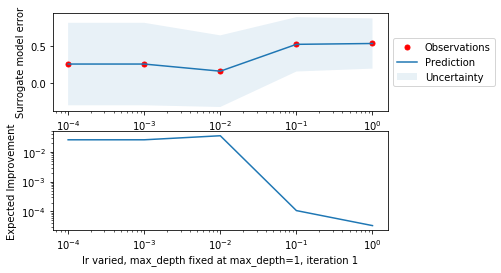

q1 callstack succesfully finished for lr varied, max_depth fixed at max_depth=1, iteration 1


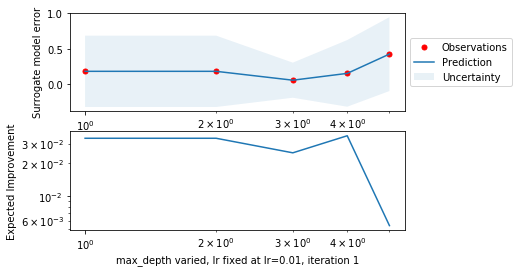

q1 callstack succesfully finished for max_depth varied, lr fixed at lr=0.01, iteration 1


In [0]:
#Generate results of the first sub-question; We define two slices, one where lr varies and max_depth is fixed,
#And one where max_depth is varied and lr is fixed. Returns the EI score. 
ei_score_learning_rate_max_depth_fixed  = q1_callstack(GBC_hyperparams, 'accuracy', learning_rate_max_depth_fixed, lr, 
                                                       'lr varied, max_depth fixed at max_depth=1, iteration 1', classification=True)

ei_score_max_depth_learning_rate_fixed = q1_callstack(GBC_hyperparams, 'accuracy', max_depth_learning_rate_fixed, max_depth, 
                                                      'max_depth varied, lr fixed at lr=0.01, iteration 1',classification=True)

#Save results to disk, so we don't have to run this again if we need it for later questions. 
with open("ei_score_learning_rate_max_depth_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_learning_rate_max_depth_fixed, f)

with open("ei_score_max_depth_learning_rate_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_max_depth_learning_rate_fixed, f)

For the first iteration, we can see that the surrogate model gives us the minimum error when learning rate is 10^-2. We are also getting the highest inspected improvement at 10^-2, which is expected by the model.
For max depth, it is not exactly what we expect. The minimum error is at max depth = 3. But the maximum expected improvement is around 4, so the Expected improvement is pointing us towards a higher max_depth. 


In [0]:
#Load the results again 
with open("ei_score_learning_rate_max_depth_fixed.pkl", "rb") as f:
     ei1 = pickle.load(f)

with open("ei_score_max_depth_learning_rate_fixed.pkl", "rb") as f:
     ei2 = pickle.load(f)


def q1_3it_callstack(random_param: np.array,                             #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    """First, we calculate the optimal hyperparameter setup 
    from the EI results in the previous question. 
    Then we repeat the procedure 3 times. This gives us a total of 4 iterations"""
    max_ei_param_1 = np.unravel_index(np.argmax(ei1, axis=None), shape=ei1.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei2,  axis=None), shape=ei2.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = lr[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = max_depth[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

New parameters sucessfully set, length of list is now 11


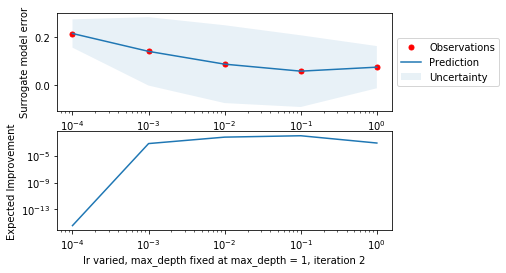

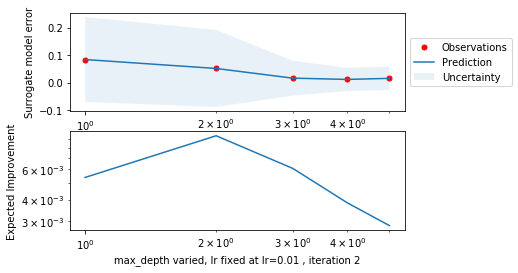

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


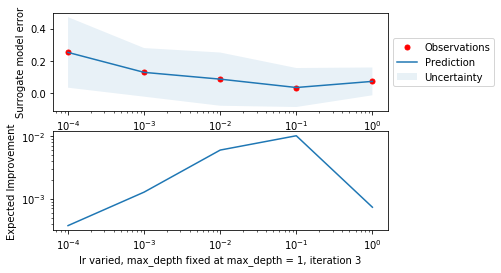

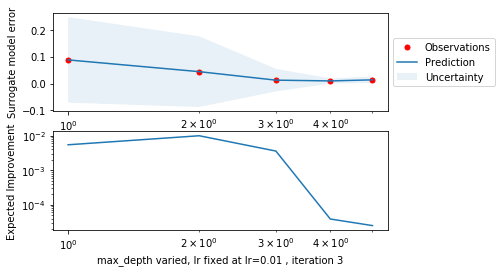

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


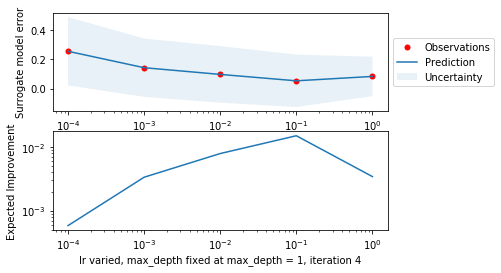

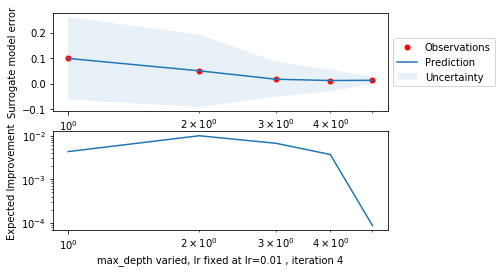

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [0]:
param_list_four_iterations_gbc = q1_3it_callstack(GBC_hyperparams, 'accuracy', learning_rate_max_depth_fixed,
                                                  max_depth_learning_rate_fixed, lr, max_depth, 
                                                  "lr varied, max_depth fixed at max_depth = 1", 
                                              "max_depth varied, lr fixed at lr=0.01 ", classification=True)

with open("param_list_four_iterations_gbc.pkl", "wb") as f:
    pickle.dump(param_list_four_iterations_gbc, f)

For the second iteration, we are getting the minimum error for the learning rate at 10^-1 and expected improvement is also maximum at 10^-1. Which is exactly what we expected. But for max depth, the minimum error is at 4, while the expected improvement is maximum at 2. 
For the third iteration, the minimum error for learning rate is also at 10^-2. And the expected improvement is also maximum at 10^-1. For max depth, it is the same as we saw in the 2nd iteration. For the fourth iteration we see similar results.


New parameters sucessfully set, length of list is now 15
Iteration 5 completed
New parameters sucessfully set, length of list is now 16
Iteration 6 completed
New parameters sucessfully set, length of list is now 17
Iteration 7 completed
New parameters sucessfully set, length of list is now 18
Iteration 8 completed
New parameters sucessfully set, length of list is now 19
Iteration 9 completed
New parameters sucessfully set, length of list is now 20
Iteration 10 completed
New parameters sucessfully set, length of list is now 21
Iteration 11 completed
New parameters sucessfully set, length of list is now 22
Iteration 12 completed
New parameters sucessfully set, length of list is now 23
Iteration 13 completed
New parameters sucessfully set, length of list is now 24
Iteration 14 completed
New parameters sucessfully set, length of list is now 25
Iteration 15 completed
New parameters sucessfully set, length of list is now 26
Iteration 16 completed
New parameters sucessfully set, length of lis

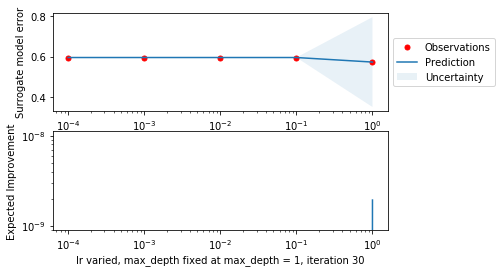

C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


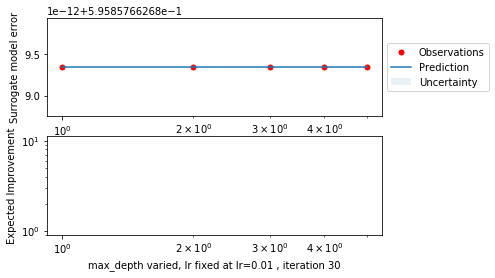

In [0]:
with open("param_list_four_iterations_gbc.pkl", "rb") as f:
    param_list_four_iterations_loaded_gbc = pickle.load(f)

final_param_list_gbc = q1_30it_callstack('accuracy', learning_rate_max_depth_fixed, max_depth_learning_rate_fixed, lr, max_depth,
                 "lr varied, max_depth fixed at max_depth = 1", "max_depth varied, lr fixed at lr=0.01 ", classification=True)

#save the results to disk for use in later questions
with open('final_param_list_gbc.pkl', 'wb') as f:
    pickle.dump(final_param_list_gbc, f)

For the 30th iteration we see that we are getting a straight line, but there is a minor improvement in error at the highest value of the learning rate parameter. We are also getting the maximum improvement at the same value of the parameter.
For max depth, we get a straight line as well. But no improvement in error at any point. We believe that is the reason we don’t get any expected improvement for error in max depth.
We also got a user warning while running that iteration, that the data has no positive values and therefore cannot be log scaled. We do not have enough time to run this again, because it takes around 4 to 5 hours and we need to submit the report, so unfortunately it is not possible.


<H3> Q1 Elastic Net <H3>

In [33]:
alpha_points = np.logspace(-12,12, 25)          #Create a range of parameter alpha, on a logarithmic scale, from 1e-12 to 1e12
l1_ratio = np.linspace(0,1, 25)

sample_alpha = np.random.choice(alpha_points, 10, replace=False) #Take a new random sample, this time without replacement as 
sample_l1 = np.random.choice(l1_ratio, 10, replace=False)        #There are enough points to sample uniquely. 

elastic_hyperparams = np.array(list(zip(sample_alpha, sample_l1)))  #Zip together learning_rate and max_depth, cast it to the right data structure (np.array)
alpha_points_l1_ratio_fixed = np.array([(l, 1) for l in alpha_points]) #Create a np.array where learning_rate varies and max_depth is fixed
l1_ratio_alpha_points_fixed = np.array([(0, m) for m in l1_ratio])     #Create a np.array where max_depth varies and learning_rate is fixed


#Re-define surrogate_model_fitter with right model (In this case, Elasticnet)
def surrogate_model_fitter(random_params, scoring_metric):
    """Function to fit the surrogate model.
     random_params: First iteration list of random params,
     later a list of random params + optimal configurations.
     scoring_metric: scoring metric to evaluate
     returns list of raw scores
     (So three scores per evaluation, one for each fold)"""
    score_list = []
    for param1, param2 in random_params:
        eln = ElasticNet(alpha=param1, l1_ratio=param2 )
        score = cross_validate(eln, Xr, yr, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list

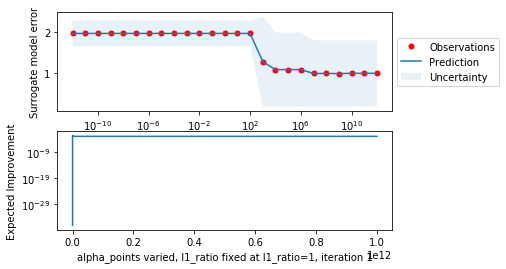

q1 callstack succesfully finished for alpha_points varied, l1_ratio fixed at l1_ratio=1, iteration 1


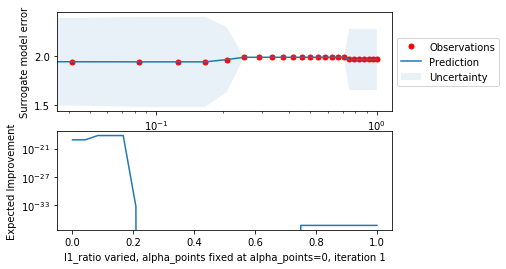

q1 callstack succesfully finished for l1_ratio varied, alpha_points fixed at alpha_points=0, iteration 1


In [26]:
#Generate results of the first sub-question; We define two slices, one where alpha_points varies and l1_ratio is fixed,
#And one where l1_ratio is varied and alpha_points is fixed. 
ei_score_alpha_points_l1_ratio_fixed  = q1_callstack(elastic_hyperparams, 'neg_mean_squared_error', 
                                                     alpha_points_l1_ratio_fixed, alpha_points, 
                                             'alpha_points varied, l1_ratio fixed at l1_ratio=1, iteration 1',
                                                     classification=False)

ei_score_l1_ratio_alpha_points_fixed = q1_callstack(elastic_hyperparams, 'neg_mean_squared_error', 
                                                    l1_ratio_alpha_points_fixed, l1_ratio, 
                                             'l1_ratio varied, alpha_points fixed at alpha_points=0, iteration 1',
                                                    classification=False)

#Save results to disk, so we don't have to run this again if we need it for later questions. 
with open("ei_score_alpha_points_l1_ratio_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_alpha_points_l1_ratio_fixed, f)

with open("ei_score_l1_ratio_alpha_points_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_l1_ratio_alpha_points_fixed, f)

While running 1st iteration for elastic net surrogate model we noticed that we are getting minimum error for lesser values of alpha and we see that we get highest expected improvement for the lowest value of alpha. The expected improvement function seems a bit off here. For l1_ratio we get very strange expected improvement and shows less error for lower value.

In [29]:
#Load the results again 
with open("ei_score_alpha_points_l1_ratio_fixed.pkl", "rb") as f:
     ei1 = pickle.load(f)

with open("ei_score_l1_ratio_alpha_points_fixed.pkl", "rb") as f:
     ei2 = pickle.load(f)

def q1_3it_callstack_elastic(random_param: np.array,                     #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    """First, we calculate the optimal hyperparameter setup 
    from the EI results in the previous question. 
    Then we repeat the procedure 3 times. This gives us a total of 4 iterations"""
    max_ei_param_1 = np.unravel_index(np.argmax(ei1, axis=None), shape=ei1.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei2,  axis=None), shape=ei2.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)                                      #Calculate the EI-score
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = alpha_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = l1_ratio[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

New parameters sucessfully set, length of list is now 11


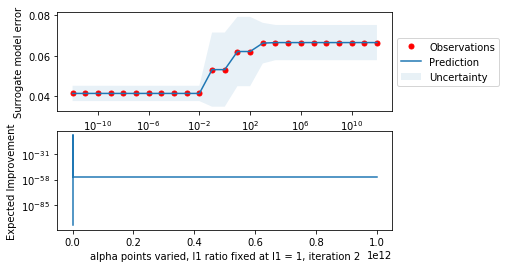

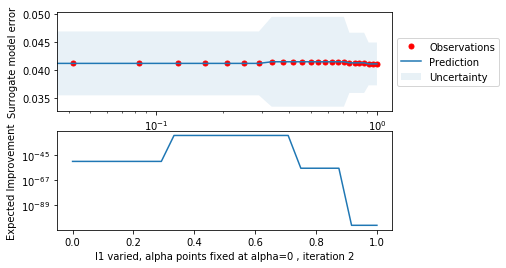

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


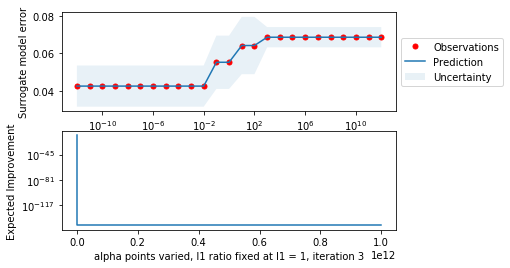

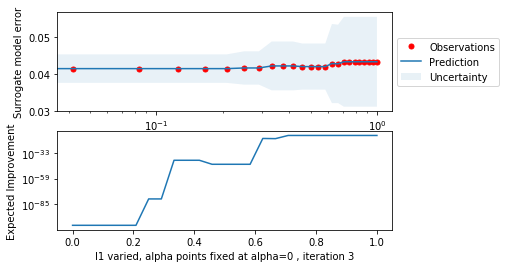

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


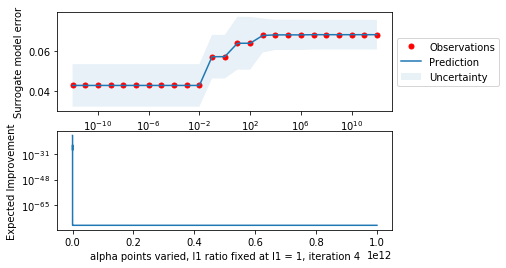

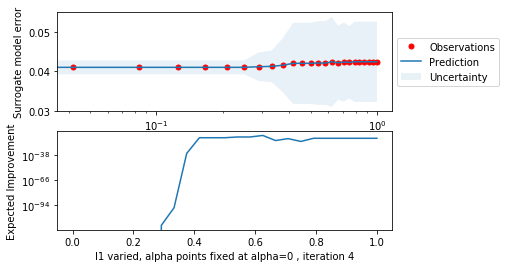

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [34]:
param_list_four_iterations = q1_3it_callstack_elastic(elastic_hyperparams, 
                                             'neg_mean_squared_error', alpha_points_l1_ratio_fixed, l1_ratio_alpha_points_fixed, 
                                              alpha_points, l1_ratio, "alpha points varied, l1 ratio fixed at l1 = 1", 
                                              "l1 varied, alpha points fixed at alpha=0 ", classification=False)

with open("param_list_four_iterations_elastic.pkl", "wb") as f:
    pickle.dump(param_list_four_iterations, f)

For second iteration we see the same pattern for alpha as the error stays low for value between 10^-12 to 10^-2 and then increases rapidly. The graph of the expected improvement looks very strange. 
The same for the l1_ratio can be seen as we saw in first iteration. The expected improvement is a bit strange it increases with the increase of error.
For third iteration we see the same pattern for alpha, with a very strange EI plot again. For l1_ratio we see that expected improvement is higher for higher values of l1_ratio. 
For the fourth iteration we can see the same pattern for alpha (complete with strange EI plot) but for l1 it changes a bit the expected improvement is again the highest in the higher regions of l1. 


In [35]:
# Re-write function for gradboost regressor
def q1_30it_callstack(random_param: np.array,   
                     scoring_metric: str,
                     fixed_slice_1: np.array, fixed_slice_2: np.array,
                     param_x_axis_1: np.array, param_x_axis_2: np.array,
                     x_axis_text1: str, x_axis_text2: str,
                     classification=True):
    new_param_list = param_list_four_iterations_loaded
    y1, sig1, rf1, =(0,0,0)
    y2, sig2, rf2, = (0,0,0)
    ei_score1, ei_score2 = (0,0)
    for i in range(26):
        score = surrogate_model_fitter(new_param_list, scoring_metric)
        rf_score = calculate_rf_input(score, classification)

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = alpha_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = l1_ratio[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list)))
        print("Iteration {} completed".format(i+5)) #Since we've already done 4 iterations and i starts @ zero
    surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration 30'.format(x_axis_text1))
    surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration 30'.format(x_axis_text2))
    return new_param_list

New parameters sucessfully set, length of list is now 15
Iteration 5 completed
New parameters sucessfully set, length of list is now 16
Iteration 6 completed
New parameters sucessfully set, length of list is now 17
Iteration 7 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 18
Iteration 8 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 19
Iteration 9 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 20
Iteration 10 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 21
Iteration 11 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 22
Iteration 12 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 23
Iteration 13 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 24
Iteration 14 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 25
Iteration 15 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)


New parameters sucessfully set, length of list is now 26
Iteration 16 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 27
Iteration 17 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 28
Iteration 18 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 29
Iteration 19 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 30
Iteration 20 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 31
Iteration 21 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 32
Iteration 22 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 33
Iteration 23 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 34
Iteration 24 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 35
Iteration 25 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 36
Iteration 26 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 37
Iteration 27 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 38
Iteration 28 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 39
Iteration 29 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.97841897567079, tolerance: 0.0370357061594951
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.93757954140463, tolerance: 0.03836607268302143
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 119.47110886888122, tolerance: 0.03842667020175718
  positive)
C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not 

New parameters sucessfully set, length of list is now 40
Iteration 30 completed


C:\Users\Yme\Anaconda3\envs\Datamining3.6\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


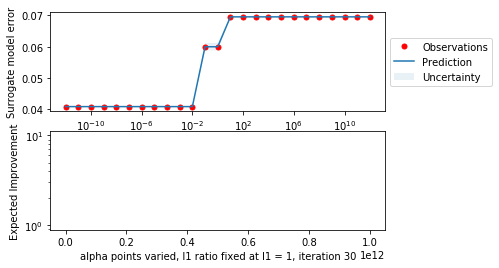

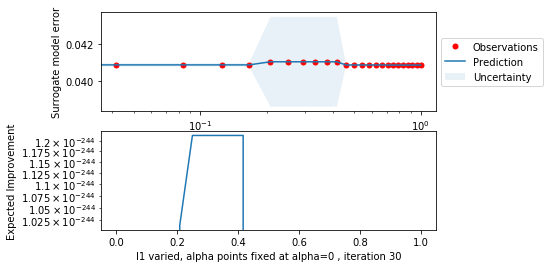

In [36]:
with open("param_list_four_iterations_elastic.pkl", "rb") as f:
    param_list_four_iterations_loaded = pickle.load(f)

final_param_list_elastic = q1_30it_callstack(elastic_hyperparams, 'neg_mean_squared_error', alpha_points_l1_ratio_fixed, l1_ratio_alpha_points_fixed, 
                                              alpha_points, l1_ratio, "alpha points varied, l1 ratio fixed at l1 = 1", 
                                              "l1 varied, alpha points fixed at alpha=0 ", classification=False)

#save the results to disk for use in later questions
with open('final_param_list_elastic.pkl', 'wb') as f:
    pickle.dump(final_param_list_elastic, f)

The plots look very weird after 30 iterations. Even though the iterations did run succesfully, they give a lot of userwarnings. Unfortunately we did not really have the time to investigate what is wrong. The error is very low for alpha in the lower regions, but the plot doesn't show any expected improvement. For l1 the error on the surrogate model is similar, but the Expected improvement also looks very strange.  

<H3> GradBoost Regressor <H3>

In [0]:
#Since the ranges of learning rate are smaller here, we define only 5 discrete values for each.
#We then draw 10 random values from each (with replacement) to get our 10 random hyperparameter setups.

lr = np.logspace(-4, 0, 5)                                       #Create a range of parameter learning_rate, on a logarithmic scale, from 1e-4 to 1e-1
max_depth = np.linspace(1,5, 5)                                  #Create a range of parameter max_depth, on a linspace scale, from 1 to 5
sample_learning_rate = np.random.choice(lr, 10)                  #Sample 10 random points out of the parameter lr range
sample_max_depth = np.random.choice(max_depth, 10)               #Sample 10 random points out of the parameter max_depth range


GBR_hyperparams = np.array(list(zip(sample_learning_rate, sample_max_depth)))  #Zip together learning_rate and max_depth, cast it to the right data structure (np.array)
learning_rate_max_depth_fixed = np.array([(l, 1) for l in lr])   #Create a np.array where learning_rate varies and max_depth is fixed
max_depth_learning_rate_fixed = np.array([(0.01, m) for m in max_depth])       #Create a np.array where max_depth varies and learning_rate is fixed

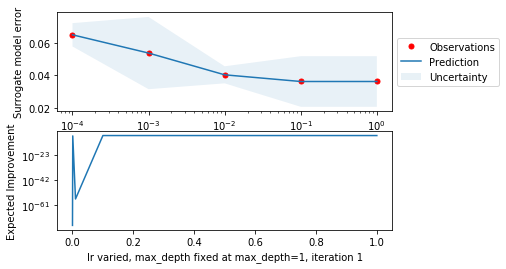

q1 callstack succesfully finished for lr varied, max_depth fixed at max_depth=1, iteration 1


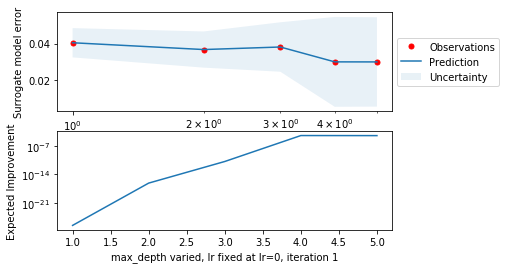

q1 callstack succesfully finished for max_depth varied, lr fixed at lr=0, iteration 1


In [0]:
#refit surrogate model, as Gradient Boost Regressor this time
def surrogate_model_fitter(random_params, scoring_metric):
    score_list = []
    for param1, param2 in random_params:
        gbr = GBR(n_estimators=1000, learning_rate=param1, max_depth=param2)
        score = cross_validate(gbr, Xr, yr, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list

#Generate results of the first sub-question; We define two slices, one where lr varies and max_depth is fixed,
#And one where max_depth is varied and lr is fixed. 
ei_score_learning_rate_max_depth_fixed_gbr  = q1_callstack(GBR_hyperparams, 'neg_mean_squared_error', 
                                                           learning_rate_max_depth_fixed, lr, 
                                                           'lr varied, max_depth fixed at max_depth=1, iteration 1',
                                                           classification=False)

ei_score_max_depth_learning_rate_fixed_gbr = q1_callstack(GBR_hyperparams, 'neg_mean_squared_error', 
                                                          max_depth_learning_rate_fixed, max_depth, 
                                                          'max_depth varied, lr fixed at lr=0, iteration 1',
                                                          classification=False)

#Save results to disk, so we don't have to run this again if we need it for later questions. 
with open("ei_score_learning_rate_max_depth_fixed_gbr.pkl", "wb") as f:
    pickle.dump(ei_score_learning_rate_max_depth_fixed_gbr, f)

with open("ei_score_max_depth_learning_rate_fixed_gbr.pkl", "wb") as f:
    pickle.dump(ei_score_max_depth_learning_rate_fixed_gbr, f)

with open("ei_score_learning_rate_max_depth_fixed_gbr.pkl", "rb") as f:
     ei1 = pickle.load(f)

with open("ei_score_max_depth_learning_rate_fixed_gbr.pkl", "rb") as f:
     ei2 = pickle.load(f)    

While running gradboost regressor, we got the minimum error at the maximum value of the learning rate. It is strange that we get the maximum expected improvement for almost all the values. We think that something went wrong because of which we get different scales for expected improvement and surrogate model error. There is much we can do because we do not have time to run it again and see what went wrong.
For max depth, we get the minimum error at 4. We also get the maximum expected improvement at 4. Which looks fine.


New parameters sucessfully set, length of list is now 11


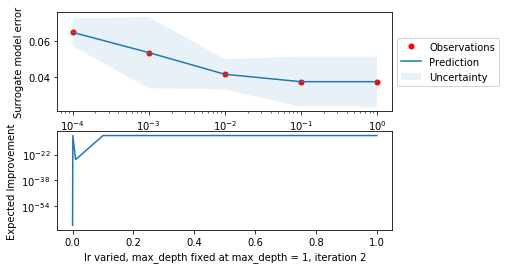

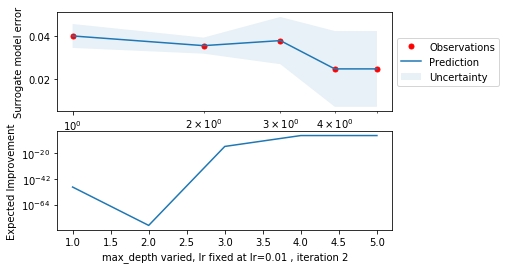

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


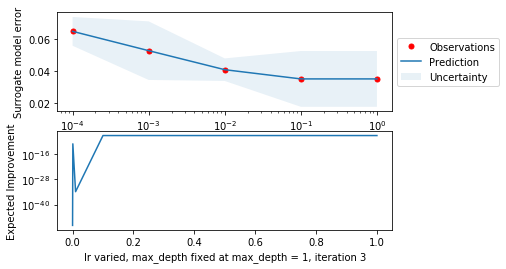

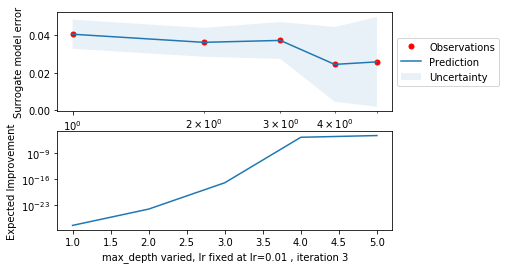

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


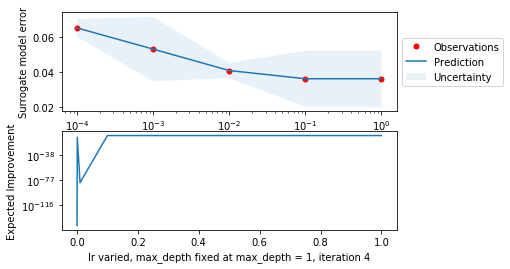

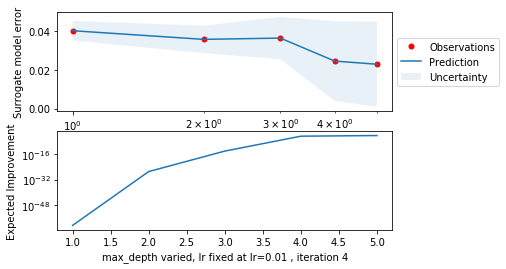

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [0]:
# rewrite 3 iterations callstack
def q1_3it_callstack_GBR(random_param: np.array,                         #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    max_ei_param_1 = np.unravel_index(np.argmax(ei1, axis=None), shape=ei1.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei2,  axis=None), shape=ei2.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)                                      #Calculate the EI-score
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = lr[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = max_depth[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

# Run 3 iterations callstack
param_list_four_iterations_gbr = q1_3it_callstack_GBR(GBR_hyperparams, 'neg_mean_squared_error', learning_rate_max_depth_fixed,
                                                      max_depth_learning_rate_fixed, lr, max_depth, 
                                                      "lr varied, max_depth fixed at max_depth = 1", 
                                                      "max_depth varied, lr fixed at lr=0.01 ", classification=False)

# Dump the results
with open("param_list_four_iterations_gbr.pkl", "wb") as f:
    pickle.dump(param_list_four_iterations_gbr, f)

For the 2nd iteration, we can also see that error for learning rate is minimum at 10^-1. The expected improvement also guides us toward the maximum value of learning rate.
For the max depth, the minimum error we can see is at 4 and the expected improvement is also at 4. It remains the same for the further values.

For the 3rd iteration we got the same results as in the 2nd iteration. There is a slight difference we can see in the surrogate model error. The error increases after 4, but expected improvement also increases which is a bit strange.

For the 4th iteration, we can see that the minimum error for learning rate is at 10^-1. But the expected improvement remains same for almost all the points. For max depth, we can see that the minimum error is at 5. But the maximum improvement remains the same between 4 and 5.


In [0]:
# Re-write function for gradboost regressor

def q1_30it_callstack(scoring_metric: str,
                     fixed_slice_1: np.array, fixed_slice_2: np.array,
                     param_x_axis_1: np.array, param_x_axis_2: np.array,
                     x_axis_text1: str, x_axis_text2: str,
                     classification = True):
    new_param_list = param_list_four_iterations_loaded
    y1, sig1, rf1, =(0,0,0)
    y2, sig2, rf2, = (0,0,0)
    ei_score1, ei_score2 = (0,0)
    for i in range(26):
        score = surrogate_model_fitter(new_param_list, scoring_metric)
        rf_score = calculate_rf_input(score, classification)

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = lr[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = max_depth[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list)))
        print("Iteration {} completed".format(i+5)) #Since we've already done 4 iterations and i starts @ zero
    surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration 30'.format(x_axis_text1))
    surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration 30'.format(x_axis_text2))
    return new_param_list

New parameters sucessfully set, length of list is now 15
Iteration 5 completed
New parameters sucessfully set, length of list is now 16
Iteration 6 completed
New parameters sucessfully set, length of list is now 17
Iteration 7 completed
New parameters sucessfully set, length of list is now 18
Iteration 8 completed
New parameters sucessfully set, length of list is now 19
Iteration 9 completed
New parameters sucessfully set, length of list is now 20
Iteration 10 completed
New parameters sucessfully set, length of list is now 21
Iteration 11 completed
New parameters sucessfully set, length of list is now 22
Iteration 12 completed
New parameters sucessfully set, length of list is now 23
Iteration 13 completed
New parameters sucessfully set, length of list is now 24
Iteration 14 completed
New parameters sucessfully set, length of list is now 25
Iteration 15 completed
New parameters sucessfully set, length of list is now 26
Iteration 16 completed
New parameters sucessfully set, length of lis

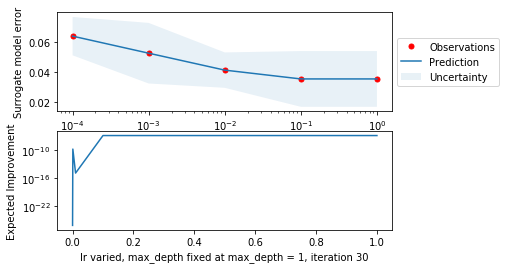

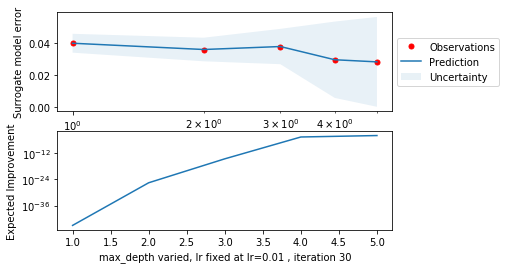

In [0]:
#Load back the results
with open("param_list_four_iterations_gbr.pkl", "rb") as f:
    param_list_four_iterations_loaded = pickle.load(f)

# call 30 iterations callstack
final_param_list_gbr = q1_30it_callstack('neg_mean_squared_error', learning_rate_max_depth_fixed, max_depth_learning_rate_fixed, lr, max_depth,
                 "lr varied, max_depth fixed at max_depth = 1", "max_depth varied, lr fixed at lr=0.01 ", classification=False)

#save the results to disk for use in later questions
with open('final_param_list_gbr.pkl', 'wb') as f:
    pickle.dump(final_param_list_gbr, f)

After we ran 30 iterations, we got the exact same results as in the 4th iteration.

## 2. Warm-starting Bayesian Optimization (20 points) {-}

* Oh no! 6 of the sensors in the first dataset (robot navigation) suddenly broke. You need to quickly retrain the model but
there is no time for a complete re-optimization.
* Revisit question 1, but additionally keep a list of the 10 best hyperparameter configurations while you run Bayesian optimization.
* Randomly remove 6 columns from the dataset (or remove them manually as long as they are not adjacent) to simulate the broken sensors.
* Re-run the Bayesian optimization (only for the first dataset), but now start from the 10 best configurations (for each classifier) rather than 10
random ones.
* Visualize the surrogate model (as before) at the initial state, and at 3 subsequent iterations.
* Interpret and discuss the results. Did the warm-start help? Could you find a good model after a few iterations? 
Explain the benefits of this approach over starting from scratch or using a random search.

As in the previous question, we first elaborate on the results of the Support vector machine. Then we re-run the code for the
GradBoostClassifier. 

In [0]:
import pandas as pd
X_nav_pandas = pd.DataFrame(X_nav).drop([3,6,9,12,15,18] ,axis=1) #Convert to a dataframe, to easily remove 6 colums (6 sensor data).
print(X_nav_pandas.shape) #Removal of sensors was succesful

(5456, 18)


In [0]:
#We now re-run the callstack from question 1, but this time with the X_Nav_pandas data where there are 6 broken sensors, and the
#10 Optimal hyperparameter setups from previous question instead of random parameters. We re-define the surrogate model-fitter,
#To fit it with X_Nav_pandas. 
def surrogate_model_fitter(random_params, scoring_metric):
    score_list = []
    for param1, param2 in random_params:
        svc = SVC(C=param1, kernel='rbf', gamma= param2)
        score = cross_validate(svc, X_nav_pandas, y_nav, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list

In [0]:
with open('final_param_list_svm.pkl', 'rb') as f:  #Open the parameter list after 30 iterations (Question 1)
    final_param_list_loaded = pickle.load(f)

scores = surrogate_model_fitter(np.array(final_param_list_loaded), 'accuracy')  #Calculate scores of SVC from the final parameter list of previous question
svc_scores = calculate_rf_input(scores, classification=True)                    #Calculate the means of the three kfolds

with open('svc_scores_10.pkl', 'wb') as f:                                      #Save these results to disk
    pickle.dump(svc_scores, f)

with open('svc_scores_10.pkl', 'rb') as f:
    svc_scores_loaded = pickle.load(f)
    
max_ten_scores = np.argsort(svc_scores_loaded)[-10:][::-1]          #Get indices at which maximum score values reside
max_parameters_svc = final_param_list_loaded[max_ten_scores]        #Use these indices to return the 10 parameter combination values that have the highest scores

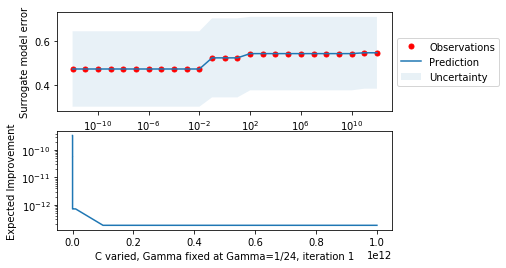

q1 callstack succesfully finished for C varied, Gamma fixed at Gamma=1/24, iteration 1


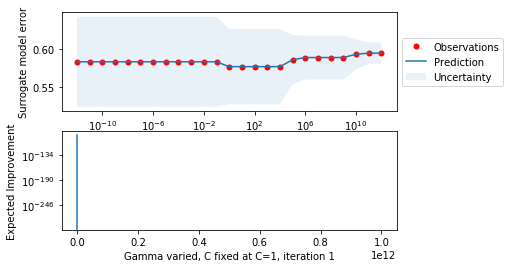

q1 callstack succesfully finished for Gamma varied, C fixed at C=1, iteration 1


In [0]:
def q1_callstack(random_param: np.array, scoring_metric: str,  
                 fixed_slice: np.array, param_x_axis:str, x_axis_text: str, classification = True):
    score = surrogate_model_fitter(random_hyperparams, scoring_metric)      #Fit the surrogate model on random hyperparams, return its score
    rf_score = calculate_rf_input(score, classification)                    #Calculate the randomforest inputs 
    y, sig, rf = random_forest_fitter(rf_score, random_param, fixed_slice)  #Fit the random forest on the random parameters, make it predict for the given slice 
    ei_score = calculate_ei(rf, fixed_slice)                                #Calculate the expected improvement on this slice
    surr_acq_plotter(param_x_axis, y, sig, ei_score, x_axis_text)           #Plot the surrogate/acquisition function
    print("q1 callstack succesfully finished for {}".format(x_axis_text))   #Print statement for some feedback 
    return ei_score

ei_score_cvaried_gamma_fixed  = q1_callstack(max_parameters_svc, 'accuracy', c_points_gamma_fixed, c_points, 
                                             'C varied, Gamma fixed at Gamma=1/24, iteration 1', classification=True)
ei_score_gamma_varied_c_fixed = q1_callstack(random_hyperparams, 'accuracy', gamma_points_c_fixed, gamma_points, 
                                             'Gamma varied, C fixed at C=1, iteration 1',classification=True)


with open("ei_score_cvaried_gamma_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_cvaried_gamma_fixed, f)

with open("ei_score_gamma_varied_c_fixed", "wb") as f:
    pickle.dump(ei_score_gamma_varied_c_fixed, f)

For the first iteration, we can see that we get the same error for C from 10^-12 to 10^-2. But we get the maximum expected improvement for the lowest value of C. For Gamma, we are getting the minimum error between 10^0 and 10^ 4. We are getting the maximum expected improvement at the lowest value of Gamma, which is a bit strange.

New parameters sucessfully set, length of list is now 11


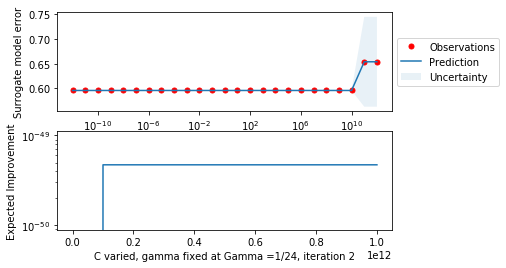

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


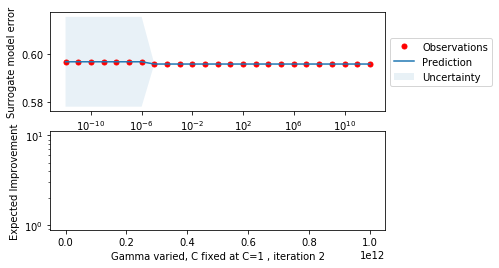

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


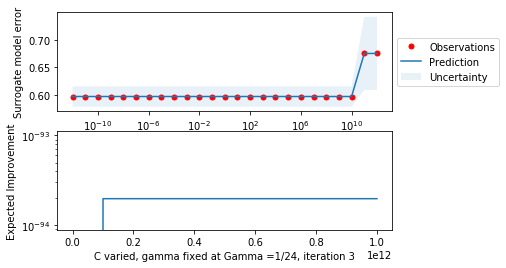

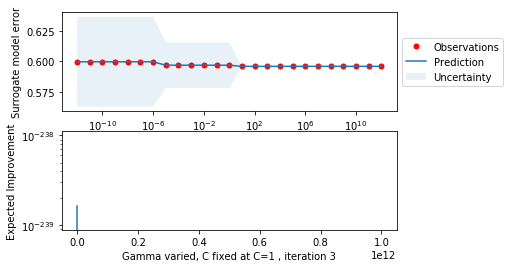

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


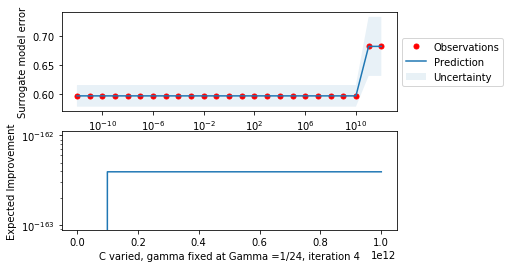

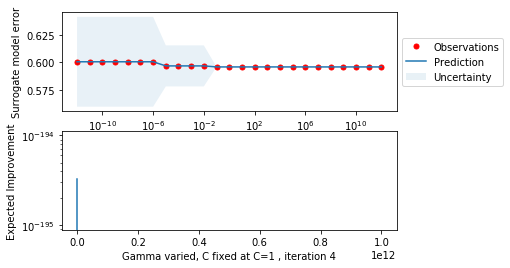

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [0]:
with open("ei_score_cvaried_gamma_fixed.pkl", "rb") as f:
    ei_score_cvaried_gamma_fixed = pickle.load(f)

with open("ei_score_gamma_varied_c_fixed", "rb") as f:
    ei_score_gamma_varied_c_fixed = pickle.load(f)


def q1_3it_callstack(random_param: np.array,                             #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    max_ei_param_1 = np.unravel_index(np.argmax(ei_score_cvaried_gamma_fixed, axis=None), shape=ei_score_cvaried_gamma_fixed.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei_score_gamma_varied_c_fixed,  axis=None), shape=ei_score_gamma_varied_c_fixed.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)                                      #Calculate the EI-score
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = c_points[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = gamma_points[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

param_list_four_iterations = q1_3it_callstack(max_parameters_svc, 'accuracy', c_points_gamma_fixed, gamma_points_c_fixed, 
                                              c_points, gamma_points, "C varied, gamma fixed at Gamma =1/24", 
                                              "Gamma varied, C fixed at C=1 ", classification=True)

with open("param_list_four_iterations.pkl", "wb") as f:
    pickle.dump(param_list_four_iterations, f)

We notice that we are getting the same user warning as we are getting in a previous question. It says the data has no positive value, and therefore cannot be log-scaled. 
We do not really get it, but we are getting more expected improvement in the regions where the error is higher for C and for Gamma.

In [0]:
#Now, we do the same for the GradBoostClassifier. 
#Define new surrogate_model_fitter, with the correct model (Gradient boost classifier). 
#We re-define the surrogate model-fitter once more, so that it fits on the data with 6 sensors broken. 
with open('final_param_list_gbc.pkl', 'rb') as f:
    final_param_list_loaded = pickle.load(f)

scores = surrogate_model_fitter(np.array(final_param_list_loaded), 'accuracy')  #Calculate scores of GBC from the final parameter list of previous question
gbc_scores = calculate_rf_input(scores, classification=True)                    #Calculate the means of the three kfolds

with open('gbc_scores_10.pkl', 'wb') as f:                                      #Save these results to disk
    pickle.dump(gbc_scores, f)
    
with open('gbc_scores_10.pkl', 'rb') as f:                                      #Save these results to disk
    gbc_scores_loaded = pickle.load(f)
    
max_ten_scores = np.argsort(gbc_scores_loaded)[-10:][::-1]          #Get indices at which maximum score values reside
max_parameters_gbc = final_param_list_loaded[max_ten_scores]        #Use these indices to return the 10 parameter combination values that have the highest scores

def surrogate_model_fitter(random_params, scoring_metric):
    score_list = []
    for param1, param2 in random_params:
        gbc = GBC(n_estimators=1000, learning_rate=param1, max_depth=param2)
        score = cross_validate(gbc, X_nav_pandas, y_nav, cv=3, scoring=[scoring_metric])
        score_list.append(score)
    return score_list

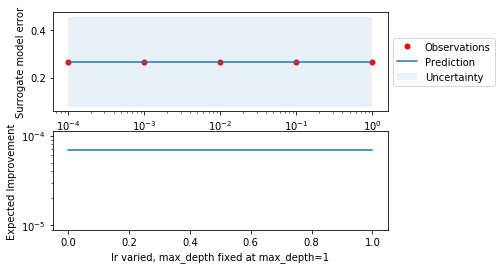

q1 callstack succesfully finished for lr varied, max_depth fixed at max_depth=1


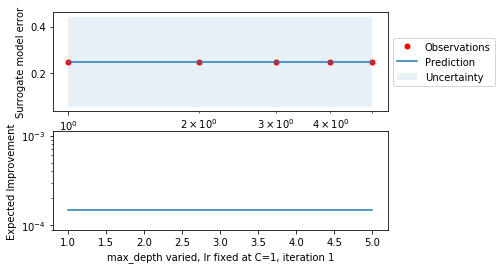

q1 callstack succesfully finished for max_depth varied, lr fixed at C=1, iteration 1


In [0]:
#Call the callstack again, this time with the GradBoost 
def q1_callstack(random_param: np.array, scoring_metric: str,  
                 fixed_slice: np.array, param_x_axis:str, x_axis_text: str, classification = True):
    score = surrogate_model_fitter(random_hyperparams, scoring_metric)      #Fit the surrogate model on random hyperparams, return its score
    rf_score = calculate_rf_input(score, classification)                    #Calculate the randomforest inputs 
    y, sig, rf = random_forest_fitter(rf_score, random_param, fixed_slice)  #Fit the random forest on the random parameters, make it predict for the given slice 
    ei_score = calculate_ei(rf, fixed_slice)                                #Calculate the expected improvement on this slice
    surr_acq_plotter(param_x_axis, y, sig, ei_score, x_axis_text)           #Plot the surrogate/acquisition function
    print("q1 callstack succesfully finished for {}".format(x_axis_text))   #Print statement for some feedback 
    return ei_score

ei_score_learning_rate_max_depth_fixed = q1_callstack(max_parameters_gbc, 'accuracy', learning_rate_max_depth_fixed, lr, 
                                             'lr varied, max_depth fixed at max_depth=1', classification=True)
ei_score_max_depth_learning_rate_fixed = q1_callstack(max_parameters_gbc, 'accuracy', max_depth_learning_rate_fixed, max_depth, 
                                             'max_depth varied, lr fixed at C=1, iteration 1',classification=True)


with open("ei_score_learning_rate_max_depth_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_learning_rate_max_depth_fixed, f)

with open("ei_score_max_depth_learning_rate_fixed.pkl", "wb") as f:
    pickle.dump(ei_score_max_depth_learning_rate_fixed, f)

For the first iteration of Gradboost classifier, we notice that we are getting a straight line. So, there is not really any improvement at any point. This might be because we are using 10 optimal parameters. 

In [0]:
with open("ei_score_learning_rate_max_depth_fixed.pkl", "rb") as f:
    ei_score_learning_rate_max_depth_fixed = pickle.load(f)

with open("ei_score_max_depth_learning_rate_fixed", "rb") as f:
    ei_score_max_depth_learning_rate_fixed = pickle.load(f)

#Call second callstack again, this time with gradboost. 
def q1_3it_callstack(random_param: np.array,                             #List of random_hyperparameters 
                     scoring_metric: str,                                #Scoring metric used (Accuracy or MSE)
                     fixed_slice_1: np.array, fixed_slice_2: np.array,   #Two fixed slices; in this case one where c varies and gamma is fixed, and another where gamma is varied and c is fixed
                     param_x_axis_1: np.array, param_x_axis_2: np.array, #Range of C and Gamma, used in plotting
                     x_axis_text1: str, x_axis_text2: str,               #Text to place on the x-axis of the plots
                     classification = True):                             #True if Classification, False otherwise
    max_ei_param_1 = np.unravel_index(np.argmax(ei_score_learning_rate_max_depth_fixed, axis=None), shape=ei_score_learning_rate_max_depth_fixed.shape)    #Get index (Hyperparameter value) at which EI is highest
    best_param1_value_1 = param_x_axis_1[max_ei_param_1]  #Use index to get best hyperparameter according to setup
    max_ei_param_2 = np.unravel_index(np.argmax(ei_score_max_depth_learning_rate_fixed,  axis=None), shape=ei_score_max_depth_learning_rate_fixed.shape) #Same, but then for slice where other hyperparameter value is fixed
    best_param1_value_2 = param_x_axis_2[max_ei_param_2]
    new_param_list = np.vstack((random_param, np.array([best_param1_value_1, best_param1_value_2])))
    print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
    for i in range(3):
        score = surrogate_model_fitter(new_param_list, scoring_metric)                    #Refit surrogate model with additional (optimal) hyperparameter setup from previous question
        rf_score = calculate_rf_input(score, classification)                              #Calculate the randomforest inputs

        y1, sig1, rf1 = random_forest_fitter(rf_score, new_param_list, fixed_slice_1)     #Fit a new random forest, for the first hyperparameter slice (In this case C, where gamma is fixed)
        ei_score1 = calculate_ei(rf1, fixed_slice_1)                                      #Calculate the EI-score
        surr_acq_plotter(param_x_axis_1, y1, sig1, ei_score1, '{}, iteration {}'.format(x_axis_text1, i+2)) #Plot the surrogate function and acquisition function of slice. i+2 because we already did an iteration
        max_ei_param_1 = np.unravel_index(np.argmax(ei_score1, axis=None), shape=ei_score1.shape)
        best_param1_value_1 = lr[max_ei_param_1]

        y2, sig2, rf2 = random_forest_fitter(rf_score, new_param_list, fixed_slice_2)
        ei_score2 = calculate_ei(rf2, fixed_slice_2)
        surr_acq_plotter(param_x_axis_2, y2, sig2, ei_score2, '{}, iteration {}'.format(x_axis_text2, i+2))
        max_ei_param_2 = np.unravel_index(np.argmax(ei_score2, axis=None), shape=ei_score2.shape)
        best_param1_value_2 = max_depth[max_ei_param_2]

        new_param_list = np.vstack((new_param_list, np.array([best_param1_value_1, best_param1_value_2])))
        print("New parameters sucessfully set, length of list is now {}".format(len(new_param_list))) #Print some feedback
        print("Iteration {} completed".format(i+2))
    return new_param_list

New parameters sucessfully set, length of list is now 11


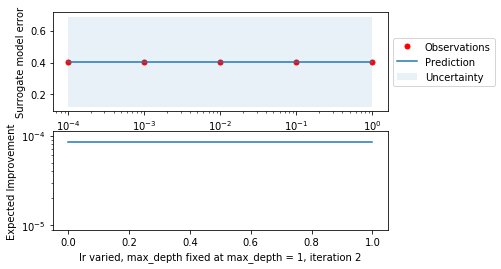

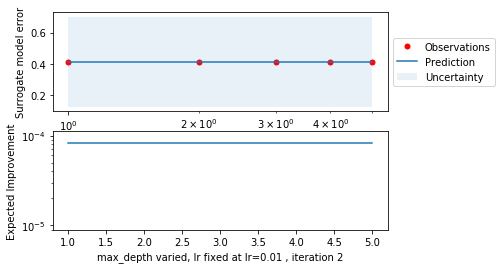

New parameters sucessfully set, length of list is now 12
Iteration 2 completed


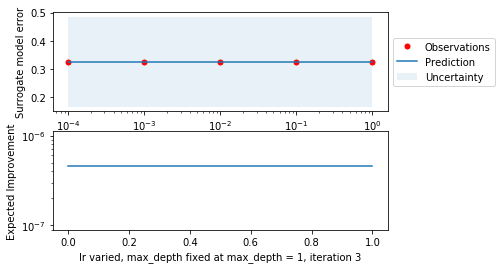

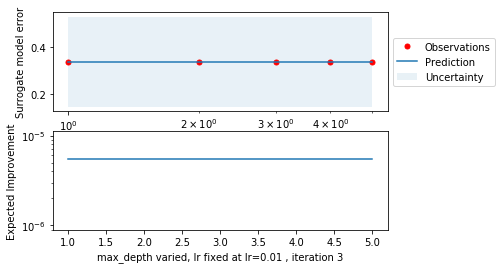

New parameters sucessfully set, length of list is now 13
Iteration 3 completed


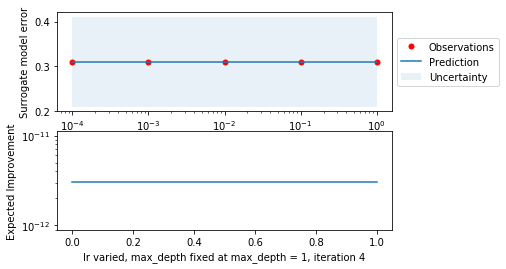

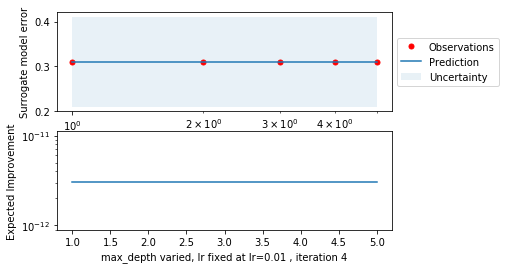

New parameters sucessfully set, length of list is now 14
Iteration 4 completed


In [0]:
param_list_four_iterations_gbc = q1_3it_callstack(max_parameters_gbc, 'accuracy', learning_rate_max_depth_fixed,
                                                  max_depth_learning_rate_fixed, lr, max_depth, 
                                                  "lr varied, max_depth fixed at max_depth = 1", 
                                              "max_depth varied, lr fixed at lr=0.01 ", classification=True)

For the 3 more iterations we see the same thing happening. The only reason we can see for this is that we are using the optimal hyperparameters.

## 3. Gaussian Processes (20 points) {-}
* Replace the probabilistic Random Forest used above with a Gaussian Process.
* Repeat the Bayesian Optimization for one of the datasets, again visualizing the surrogate model and the acquisition function.
* If the surrogate models do not look right, do manual tuning
- Hint: Try `y_normalize`, regularizing the `alpha` hyperparameter, or trying a different kernel.
* Interpret and discuss the results. In which ways are the Gaussian Processes better or worse? Consider both accuracy, speed of finding a good configuration, and runtime. Interpret and explain the results as well as you can.

In [0]:
# We Define a class for probabilistic gaussian process

from sklearn.gaussian_process import GaussianProcessRegressor

class ProbablisticGaussianProcess(GaussianProcessRegressor):
    
    def predict(self, X, return_std=True, return_cov=False):
        return super().predict(X, return_std)

In [0]:
#Re-define some functions so they are using a Gaussian process

def calculate_gp_input(score_list_model, classification=True):
    """Function that converts the raw score_list from
    surrogate_model_fitter into a workable value to input into the
    later the Gaussian process"""
    if classification:
        gp_input = np.array([1 - np.mean(i['test_accuracy']) for i in score_list_model])
    else:
        gp_input = np.array([abs(np.mean(i['test_neg_mean_squared_error'])) for i in score_list_model])
    return gp_input

def random_gaussian_process(score_to_fit, random_params, fixed_slice):
    gp = ProbablisticGaussianProcess(normalize_y=True, alpha=1e-10)
    gp.fit(random_params, score_to_fit)
    Y_pred, sigma = gp.predict(fixed_slice, return_std=True)
    return Y_pred, sigma, gp


def calculate_ei_score_gaussian(gaussian_param, fixed_slice):
    """Calculate expected improvement"""
    return EI(gaussian_param, fixed_slice)

In [0]:
alpha_points = np.logspace(-12,12, 25)              #Create a range of parameter c, on a logarithmic scale, from 1e-12 to 1e12
l1_ratio = np.linspace(0,1, 25)

sample_alpha = np.random.choice(alpha_points, 10, replace=False) #Take a new random sample, this time without replacement as 
sample_l1 = np.random.choice(l1_ratio, 10, replace=False)        #There are enough points to sample uniquely. 

elastic_hyperparams = np.array(list(zip(sample_alpha, sample_l1)))  #Zip together learning_rate and max_depth, cast it to the right data structure (np.array)
alpha_points_l1_ratio_fixed = np.array([(l, 1) for l in alpha_points])  #Create a np.array where learning_rate varies and max_depth is fixed
l1_ratio_alpha_points_fixed = np.array([(0, m) for m in l1_ratio])     #Create a np.array where max_depth varies and learning_rate is fixed

#Re-define and call the callstack so that it works with a gaussian process for the SVM
def q1_callstack(random_param: np.array, scoring_metric: str,  
                 fixed_slice: np.array, param_x_axis:str, x_axis_text: str, classification=True):
    score = surrogate_model_fitter(random_hyperparams, scoring_metric)      #Fit the surrogate model on random hyperparams, return its score
    gp_score = calculate_gp_input(score, classification)                    #Calculate the randomforest inputs 
    y, sig, gp = random_gaussian_process(gp_score, random_param, fixed_slice)  #Fit the random forest on the random parameters, make it predict for the given slice 
    ei_score = calculate_ei_score_gaussian(gp, fixed_slice)                 #Calculate the expected improvement on this slice
    surr_acq_plotter(param_x_axis, y, sig, ei_score, x_axis_text)           #Plot the surrogate/acquisition function
    print("q1 callstack succesfully finished for {}".format(x_axis_text))   #Print statement for some feedback 
    return ei_score

ei_score_cvaried_gamma_fixed_gp  = q1_callstack(elastic_hyperparams, 'neg_mean_squared_error', 
                                                alpha_points_l1_ratio_fixed, alpha_points, 
                                             'alpha_points varied, l1_ratio fixed at l1_ratio=1, iteration 1',
                                                classification=False)
ei_score_gamma_varied_c_fixed_gp = q1_callstack(random_hyperparams, 'neg_mean_squared_error', 
                                                l1_ratio_alpha_points_fixed, l1_ratio, 
                                             'l1_ratio varied, alpha_points fixed at alpha_points=0, iteration 1',
                                                classification=False)



![alt text](https://user-images.githubusercontent.com/53309799/68501829-5c2fb300-025f-11ea-91be-9fa2c1021037.png)

![alt text](https://user-images.githubusercontent.com/53309799/68501828-5c2fb300-025f-11ea-80b1-f9dd1475c0ff.png)



While running Gaussian process with elasticNet we see that, for varied alpha, the surrogate model give us an error of +- 0.The expected improvement function looks very strange (It is the same for all points). For l1 ratio varied we see that the error is also approximately zero, however uncertainty seems to increase when l1 is closer to one, and the EI function corresponds with that by indicating that the most expected improvement is to be found there. 

In [0]:
#GradBoost Regressor. #Since the ranges of learning rate are smaller here, we define only 5 discrete values for each.
#We then draw 10 random values from each (with replacement) to get our 10 random hyperparameter setups.

lr = np.logspace(-4, 0, 5)                          #Create a range of parameter learning_rate, on a logarithmic scale, from 1e-4 to 1e-1
max_depth = np.linspace(1,5, 5)                     #Create a range of parameter max_depth, on a linspace scale, from 1 to 5
sample_learning_rate = np.random.choice(lr, 10)     #Sample 10 random points out of the parameter lr range
sample_max_depth = np.random.choice(max_depth, 10)  #Sample 10 random points out of the parameter max_depth range


GBR_hyperparams = np.array(list(zip(sample_learning_rate, sample_max_depth)))  #Zip together learning_rate and max_depth, cast it to the right data structure (np.array)
learning_rate_max_depth_fixed = np.array([(l, 1) for l in lr])   #Create a np.array where learning_rate varies and max_depth is fixed
max_depth_learning_rate_fixed = np.array([(0.01, m) for m in max_depth])       #Create a np.array where max_depth varies and learning_rate is fixed

#Call callstack again, this time for GBC

ei_score_learning_rate_max_depth_fixed_gp  = q1_callstack(GBR_hyperparams, 'neg_mean_squared_error', 
                                                          learning_rate_max_depth_fixed, lr, 
                                                       'lr varied, max_depth fixed at max_depth=1,iteration 1',
                                                          classification=False)

ei_score_max_depth_learning_rate_fixed_gp = q1_callstack(GBR_hyperparams, 'neg_mean_squared_error', 
                                                         max_depth_learning_rate_fixed, max_depth, 
                                                      'max_depth varied, lr fixed at lr=0.01, iteration 1',
                                                         classification=False)

![alt text](https://user-images.githubusercontent.com/53309799/68501827-5c2fb300-025f-11ea-8a30-5a64c41ed614.png)

![alt text](https://user-images.githubusercontent.com/53309799/68501826-5c2fb300-025f-11ea-94ff-3afb37f237fe.png)

While running Gaussian process with GradBoost Regressor we see that there is almost no deflections at any point and we almost get same expected improvement for learning rate.
The same we see with max_depth also but here we see very high expected improvement at max_depth = 5. 

Concluding this assignment we can see how Bayesian optimization might be useful to do hyperparameter tuning in a structured way. 
That being said, we have the feeling that we haven't yet reached its full potential by doing this assignment. A lot of expected
improvement plots turned out to be strange, and sometimes the optimal hyperparameter setups were not obtained at the largest 
iterations, which is also strange for an algorithm that should keep "improving" hyperparameter scores.